<a href="https://colab.research.google.com/github/umamah333/Enhanced-MRI-Analysis-for-Brain-Tumour-Classification-using-Machine-Learning/blob/main/some%20changes%20in%20code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pydot graphviz  #installing packages to use graphics in python
!apt-get install -y graphviz # to create graphs or flowcharts
!pip install Pillow

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


# **Libraries**

In [ ]:
#General Libraries
#-----------------------------------------------------------------------------------
import os  # For operating system related operations such as file and directory management
import numpy as np  # For numerical operations and array manipulations
import pandas as pd  # For data manipulation and analysis
import matplotlib.pyplot as plt  # For creating static, animated, and interactive visualizations
import seaborn as sns  # For making statistical graphics in Python

#Machine Learning and Deep Learning Libraries
#-------------------------------------------------------------------------------------------------------------------------------------------------------------
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc  # For evaluation metrics and performance analysis
from sklearn.svm import SVC  # For Support Vector Classification
from sklearn.preprocessing import StandardScaler, label_binarize  # For data preprocessing
from sklearn.pipeline import make_pipeline  # For creating machine learning pipelines
import tensorflow as tf  # Core library for neural networks and deep learning
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # For image data augmentation and preprocessing
from tensorflow.keras.models import Sequential, Model  # For building neural network models
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout  # For different layers in CNN
from tensorflow.keras.optimizers import Adam  # For optimizer algorithms in training neural networks
from tensorflow.keras.utils import to_categorical  # For converting a vector of labels to a binary matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.callbacks import EarlyStopping

#Image Processing Libraries
#---------------------------------------------------------------------------------------------------------------
from PIL import Image  # For image processing and opening images
import cv2  # For image processing and computer vision tasks
import imutils  # For image processing and computer vision convenience functions



#Utility Libraries
#-----------------------------------------------------------------------------------------------------------------
from tqdm import tqdm  # For displaying progress bars
import random  # For generating random numbers and making random choices
import shutil  # For file operations such as copying and moving files

#Visualization Libraries
#----------------------------------------------------------------------------------------------------------------------
import pydot  # For graph and network visualizations
from IPython.display import Image, display  # For displaying images in Jupyter notebooks

#Google Colab Specific
#--------------------------------------------------------------------------------------------------------------------------
from google.colab import drive  # For mounting Google Drive to access files stored in Google Drive


# **Dataset Unzipping and viewing the contents**
The frist step is to load and unzip the data, and to view its contents

In [ ]:
#mounting the google drive because dataset is loaded in the drive for easy access and
#further processing


drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#making seperate file for unzipping the contents of the dataset in the folder
# it would create a folder of the images into a seperate folder and will also keep the zipped folder in drive aswell.

!mkdir -p "/content/drive/My Drive/brain_tumor_dataset"

In [ ]:
#unzipping the dataset

!unzip "/content/drive/My Drive/brain tumour dataset.zip" -d "/content/drive/My Drive/brain_tumor_dataset"

Streaming output truncated to the last 5000 lines.
  inflating: /content/drive/My Drive/brain_tumor_dataset/Training/glioma/Tr-gl_0712.jpg  
  inflating: /content/drive/My Drive/brain_tumor_dataset/Training/glioma/Tr-gl_0713.jpg  
  inflating: /content/drive/My Drive/brain_tumor_dataset/Training/glioma/Tr-gl_0714.jpg  
  inflating: /content/drive/My Drive/brain_tumor_dataset/Training/glioma/Tr-gl_0715.jpg  
  inflating: /content/drive/My Drive/brain_tumor_dataset/Training/glioma/Tr-gl_0716.jpg  
  inflating: /content/drive/My Drive/brain_tumor_dataset/Training/glioma/Tr-gl_0717.jpg  
  inflating: /content/drive/My Drive/brain_tumor_dataset/Training/glioma/Tr-gl_0718.jpg  
  inflating: /content/drive/My Drive/brain_tumor_dataset/Training/glioma/Tr-gl_0719.jpg  
  inflating: /content/drive/My Drive/brain_tumor_dataset/Training/glioma/Tr-gl_0720.jpg  
  inflating: /content/drive/My Drive/brain_tumor_dataset/Training/glioma/Tr-gl_0721.jpg  
  inflating: /content/drive/My Drive/brain_tumor_

In [ ]:

# Count the number of directories
num_dirs = !find "/content/drive/My Drive/brain_tumor_dataset" -type d | wc -l
print(f"Number of directories: {num_dirs[0]}")

# Count the number of files
num_files = !find "/content/drive/My Drive/brain_tumor_dataset" -type f | wc -l
print(f"Number of files: {num_files[0]}")

# Count the number of images (jpg and png)
num_images = !find "/content/drive/My Drive/brain_tumor_dataset" -type f \( -iname \*.jpg -o -iname \*.png \) | wc -l
print(f"Number of images: {num_images[0]}")

Number of directories: 11
Number of files: 7023
Number of images: 7023


In [ ]:

# List all directories recursively

print("\nAll directories recursively:")
!find "/content/drive/My Drive/brain_tumor_dataset" -type d


All directories recursively:
/content/drive/My Drive/brain_tumor_dataset
/content/drive/My Drive/brain_tumor_dataset/Testing
/content/drive/My Drive/brain_tumor_dataset/Testing/glioma
/content/drive/My Drive/brain_tumor_dataset/Testing/meningioma
/content/drive/My Drive/brain_tumor_dataset/Testing/notumor
/content/drive/My Drive/brain_tumor_dataset/Testing/pituitary
/content/drive/My Drive/brain_tumor_dataset/Training
/content/drive/My Drive/brain_tumor_dataset/Training/glioma
/content/drive/My Drive/brain_tumor_dataset/Training/meningioma
/content/drive/My Drive/brain_tumor_dataset/Training/notumor
/content/drive/My Drive/brain_tumor_dataset/Training/pituitary


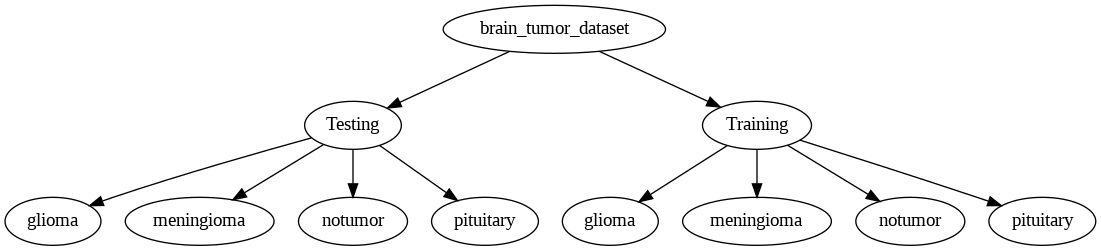

In [ ]:

def gather_directory_structure(path):
    """
    Gathers the directory structure in a nested dictionary.

    Args:
        path: The path to the directory to display.

    Returns:
        A nested dictionary representing the directory structure.
    """
    structure = {}
    for item in os.listdir(path):
        full_path = os.path.join(path, item)
        if os.path.isdir(full_path):
            structure[item] = gather_directory_structure(full_path)  # Recursively gather subdirectory structure
    return structure

def add_nodes_edges(graph, structure, parent_name="root"):
    """
    Adds nodes and edges to the graph based on the directory structure.

    Args:
        graph: The pydot graph object.
        structure: The nested dictionary representing the directory structure.
        parent_name: The name of the parent node.
    """
    for key, value in structure.items():
        node_name = f"{parent_name}/{key}"  # Create a unique name for the node
        graph.add_node(pydot.Node(node_name, label=key))  # Add a node to the graph
        graph.add_edge(pydot.Edge(parent_name, node_name))  # Add an edge from the parent to the node
        if value:  # If the directory contains other directories
            add_nodes_edges(graph, value, node_name)  # Recursively add nodes and edges for subdirectories

# Replace with your actual directory path
path = "/content/drive/My Drive/brain_tumor_dataset"

structure = gather_directory_structure(path)  # Gather the directory structure into a nested dictionary

graph = pydot.Dot(graph_type='digraph', rankdir='TB')  # Create a new directed graph, TB = top to bottom layout
graph.add_node(pydot.Node("root", label=os.path.basename(path)))  # Add the root node with the directory name
add_nodes_edges(graph, structure, "root")  # Add nodes and edges based on the directory structure

# Save the graph to a file
graph.write_png('directory_tree.png')  # Save the graph as a PNG image

# Display the graph in Google Colab
display(Image(filename='directory_tree.png'))  # Display the saved PNG image


# **Exploring the Data Structures**

In [ ]:
# Define the base directory where the dataset is stored
base_dir = "/content/drive/My Drive/brain_tumor_dataset"

# Define the paths for the training and testing directories
train_dir = os.path.join(base_dir, 'Training')
test_dir = os.path.join(base_dir, 'Testing')

# List all categories (subdirectories) in the training and testing directories
train_categories = os.listdir(train_dir)
test_categories = os.listdir(test_dir)

# Print the names of the categories in the training and testing datasets
print("Training categories:", train_categories)
print("Testing categories:", test_categories)

# For each category in the training set, print the number of images it contains
for category in train_categories:
    print(f"{category} has {len(os.listdir(os.path.join(train_dir, category)))} images in the training set")

# For each category in the testing set, print the number of images it contains
for category in test_categories:
    print(f"{category} has {len(os.listdir(os.path.join(test_dir, category)))} images in the testing set")


Training categories: ['glioma', 'meningioma', 'notumor', 'pituitary']
Testing categories: ['glioma', 'meningioma', 'notumor', 'pituitary']
glioma has 1321 images in the training set
meningioma has 1339 images in the training set
notumor has 1595 images in the training set
pituitary has 1457 images in the training set
glioma has 300 images in the testing set
meningioma has 306 images in the testing set
notumor has 405 images in the testing set
pituitary has 300 images in the testing set


Image: Tr-glTr_0000.jpg | Size: (512, 512)
Image: Tr-glTr_0001.jpg | Size: (512, 512)
Image: Tr-glTr_0002.jpg | Size: (512, 512)
Image: Tr-glTr_0003.jpg | Size: (512, 512)
Image: Tr-glTr_0004.jpg | Size: (512, 512)
Image: Tr-meTr_0000.jpg | Size: (512, 512)
Image: Tr-meTr_0001.jpg | Size: (512, 512)
Image: Tr-meTr_0002.jpg | Size: (512, 512)
Image: Tr-meTr_0003.jpg | Size: (512, 512)
Image: Tr-meTr_0004.jpg | Size: (512, 512)
Image: Tr-noTr_0000.jpg | Size: (350, 350)
Image: Tr-noTr_0001.jpg | Size: (350, 350)
Image: Tr-noTr_0002.jpg | Size: (605, 613)
Image: Tr-noTr_0003.jpg | Size: (562, 592)
Image: Tr-noTr_0004.jpg | Size: (442, 442)
Image: Tr-piTr_0000.jpg | Size: (512, 512)
Image: Tr-piTr_0001.jpg | Size: (512, 512)
Image: Tr-piTr_0002.jpg | Size: (512, 512)
Image: Tr-piTr_0003.jpg | Size: (512, 512)
Image: Tr-piTr_0004.jpg | Size: (512, 512)


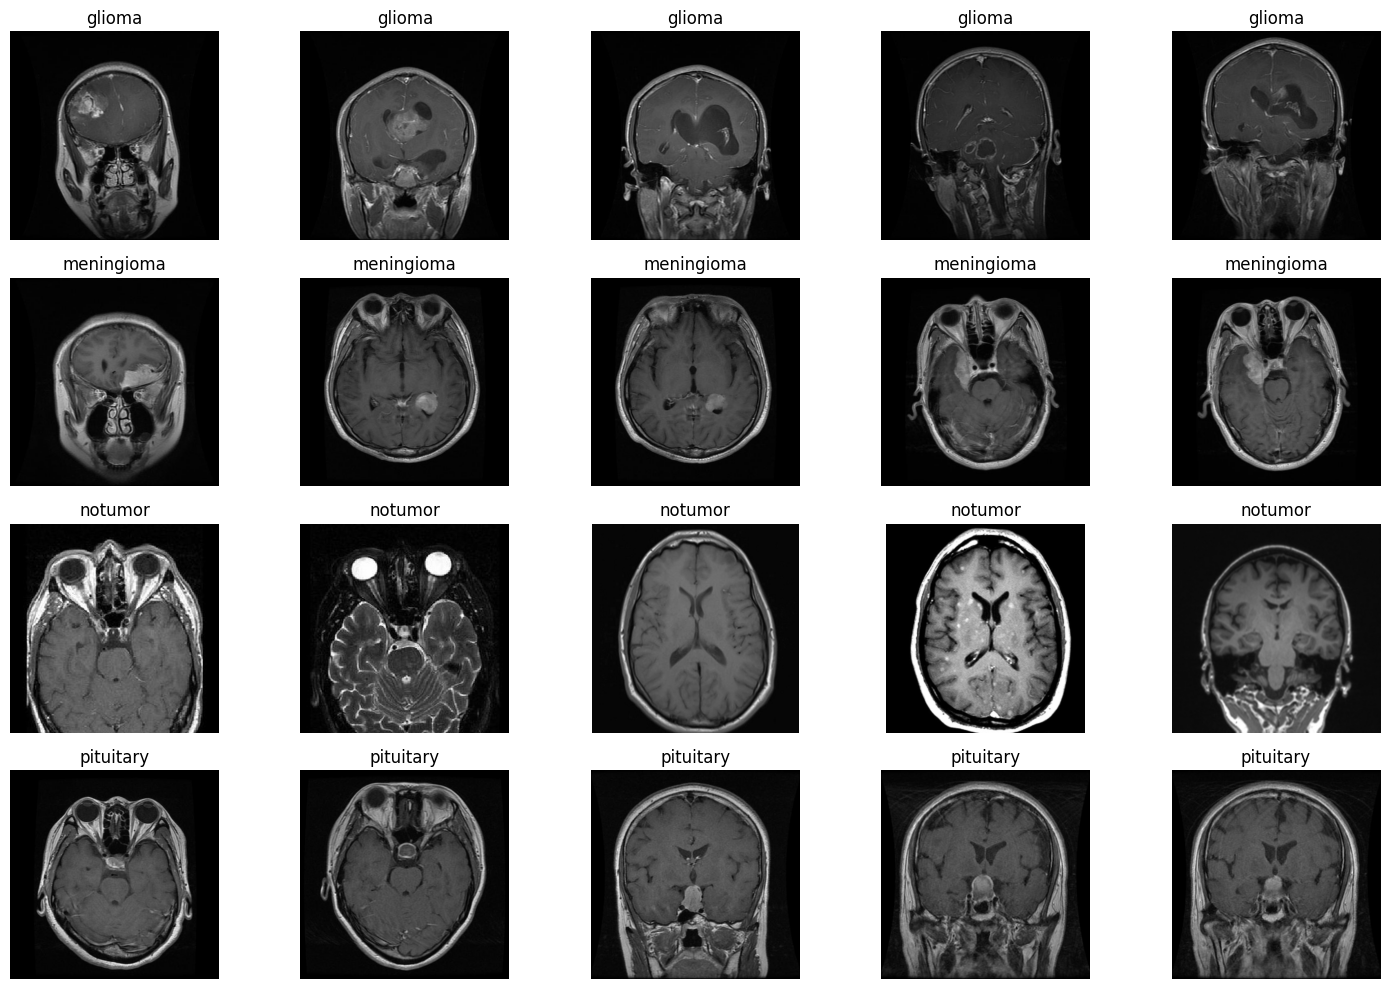

In [ ]:
from PIL import Image  # Correctly import Image from PIL

def plot_sample_images(base_dir, categories, n=5):
    """
    Plots sample images from each category in the specified base directory and prints their sizes.

    Parameters:
    base_dir (str): The base directory containing category folders.
    categories (list of str): List of category names (subdirectory names).
    n (int): Number of sample images to display from each category. Default is 5.

    The function will create a plot with sample images from each category for visualization and print their sizes.
    """
    # Set up the figure with a specified size
    plt.figure(figsize=(15, 10))

    # Loops over each category
    for i, category in enumerate(categories):
        # Get the path to the current category folder
        folder_path = os.path.join(base_dir, category)

        # Loops over the first 'n' images in the current category folder
        for j, img_name in enumerate(os.listdir(folder_path)[:n]):
            # Get the path to the current image
            img_path = os.path.join(folder_path, img_name)

            # Opens the image
            img = Image.open(img_path)

            # Creates a subplot in the current figure
            plt.subplot(len(categories), n, i * n + j + 1)

            # Displays the image
            plt.imshow(img)

            # Sets the title of the subplot to the category name
            plt.title(category)

            # Removes the axis for clarity
            plt.axis('off')

            # Prints the image name and size (width, height)
            print(f"Image: {img_name} | Size: {img.size}")

    # Adjusts the layout to prevent overlap
    plt.tight_layout()

    # Displays the plot
    plt.show()

# Calling the function to plot sample images from the training directory
plot_sample_images(train_dir, train_categories)


# **Data Pre-processing**

the images in the dataset are of different sizes ,so we will implement a technique the crop images to equal sizes for better
performance.

In [ ]:

def crop_img(img):
    """
    Finds the extreme points on the image and crops the rectangular region out of them.
    """
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)  # Convert the image to grayscale
    gray = cv2.GaussianBlur(gray, (3, 3), 0)  # Apply Gaussian blur to the grayscale image

    # Threshold the image, then perform erosions and dilations to remove small noise regions
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in the thresholded image and grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)

    # Find the extreme points of the largest contour
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    ADD_PIXELS = 0

    # Crop the image based on the extreme points
    new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()

    return new_img  # Return the cropped image

def process_images(input_dir, output_dir, img_size=256):
    """
    Processes images in the input directory by cropping and resizing, then saves them to the output directory.

    Args:
        input_dir (str): Path to the input directory containing images.
        output_dir (str): Path to the output directory to save processed images.
        img_size (int): Desired size of the output images (default is 256x256).
    """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)  # Create the output directory if it doesn't exist

    for category in os.listdir(input_dir):
        category_path_input = os.path.join(input_dir, category)  # Path to the category folder in the input directory
        category_path_output = os.path.join(output_dir, category)  # Path to the category folder in the output directory

        if not os.path.exists(category_path_output):
            os.makedirs(category_path_output)  # Create the category folder in the output directory if it doesn't exist

        for img_name in os.listdir(category_path_input):
            img_path_input = os.path.join(category_path_input, img_name)  # Path to the individual image
            image = cv2.imread(img_path_input)  # Read the image
            if image is not None:
                new_img = crop_img(image)  # Crop the image
                new_img = cv2.resize(new_img, (img_size, img_size))  # Resize the image
                img_path_output = os.path.join(category_path_output, img_name)  # Path to save the processed image
                cv2.imwrite(img_path_output, new_img)  # Save the processed image

if __name__ == "__main__":
    # Define paths for the output directories for training and testing sets
    output_training_dir = "cleaned/Training"
    output_testing_dir = "cleaned/Testing"

    # Process images in the training and testing directories
    process_images(train_dir, output_training_dir)
    process_images(test_dir, output_testing_dir)


Image: Tr-gl_0802.jpg | Size: (256, 256)
Image: Tr-gl_0438.jpg | Size: (256, 256)
Image: Tr-gl_0177.jpg | Size: (256, 256)
Image: Tr-gl_0378.jpg | Size: (256, 256)
Image: Tr-gl_0389.jpg | Size: (256, 256)
Image: Tr-me_0086.jpg | Size: (256, 256)
Image: Tr-me_0118.jpg | Size: (256, 256)
Image: Tr-me_0533.jpg | Size: (256, 256)
Image: Tr-me_0105.jpg | Size: (256, 256)
Image: Tr-me_0344.jpg | Size: (256, 256)
Image: Tr-no_0119.jpg | Size: (256, 256)
Image: Tr-no_0313.jpg | Size: (256, 256)
Image: Tr-no_1301.jpg | Size: (256, 256)
Image: Tr-no_0799.jpg | Size: (256, 256)
Image: Tr-no_0547.jpg | Size: (256, 256)
Image: Tr-pi_0779.jpg | Size: (256, 256)
Image: Tr-piTr_0005.jpg | Size: (256, 256)
Image: Tr-pi_0341.jpg | Size: (256, 256)
Image: Tr-pi_0713.jpg | Size: (256, 256)
Image: Tr-pi_0704.jpg | Size: (256, 256)


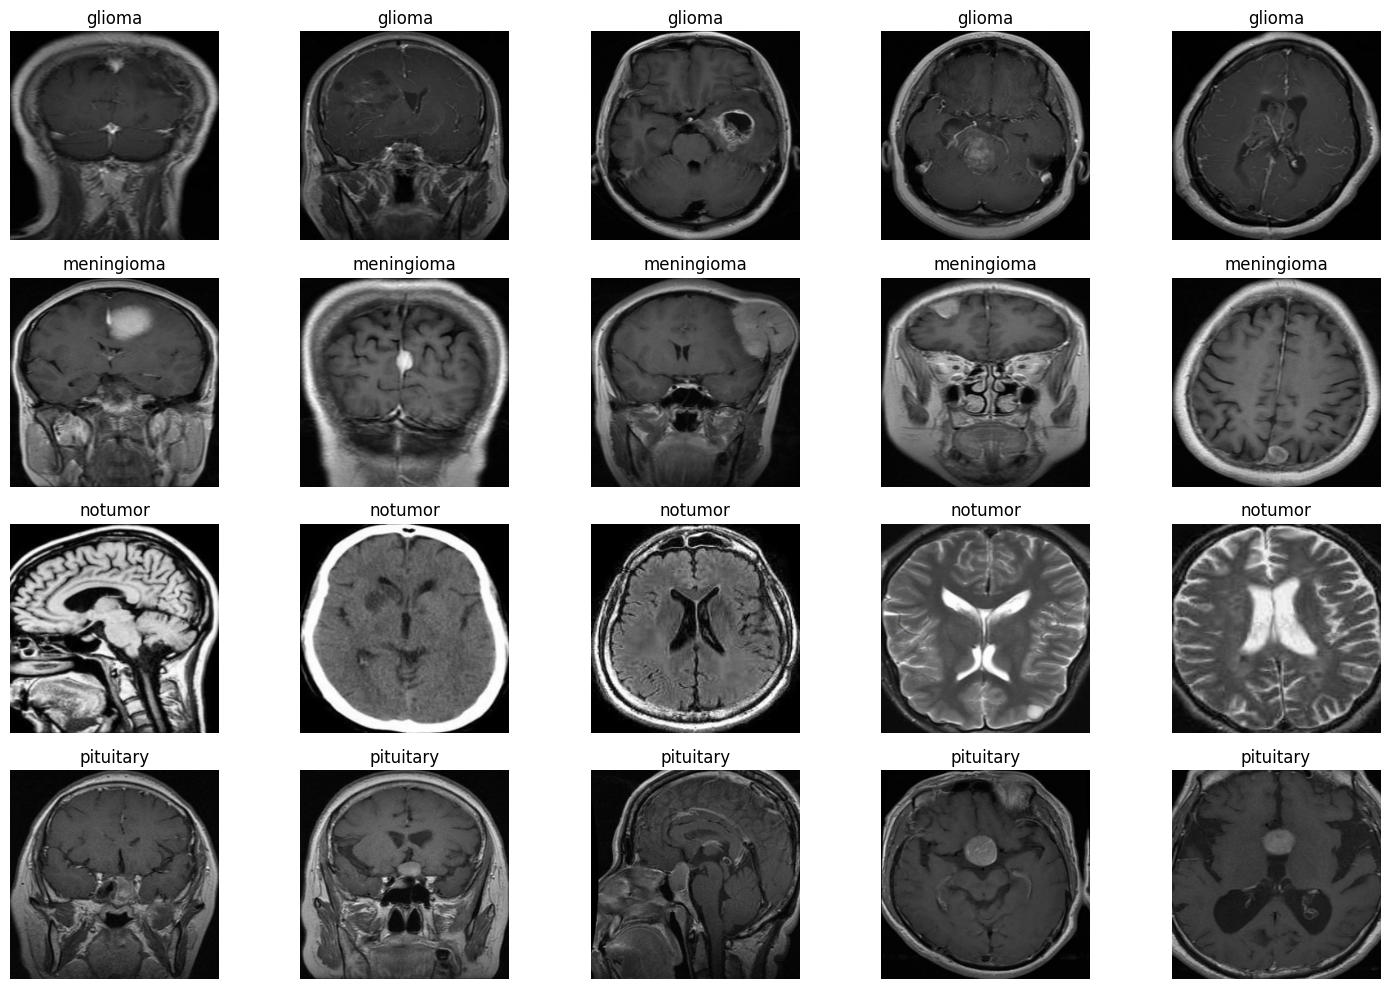

In [ ]:
#function for viewing the dataset images after cropping the images and bringing them to the standard size

def plot_sample_images(base_dir, categories, n=5):
    """
    Plots sample images from each category in the specified base directory and prints their sizes.

    Parameters:
    base_dir (str): The base directory containing category folders.
    categories (list of str): List of category names (subdirectory names).
    n (int): Number of sample images to display from each category. Default is 5.

    The function will create a plot with sample images from each category for visualization and print their sizes.
    """
    plt.figure(figsize=(15, 10))
    for i, category in enumerate(categories):
        folder_path = os.path.join(base_dir, category)
        for j, img_name in enumerate(os.listdir(folder_path)[:n]):
            img_path = os.path.join(folder_path, img_name)
            img = Image.open(img_path)
            plt.subplot(len(categories), n, i * n + j + 1)
            plt.imshow(img)
            plt.title(category)
            plt.axis('off')
            print(f"Image: {img_name} | Size: {img.size}")  # Print image size (width, height)
    plt.tight_layout()
    plt.show()

plot_sample_images(output_training_dir, train_categories)

# **Exploratory Data Analysis**

Exploring the processed dataset through EDA is crucial to grasp its contents thoroughly. This step helps detect and address potential biases and ensures all data categories are adequately represented. By analyzing the dataset, we gain insights into class distributions, assess category balance, and identify any anomalies that could impact algorithm development. This proactive approach ensures our dataset mirrors real-world scenarios, enhancing the reliability of our machine learning models. EDA guides decisions on data preprocessing, feature engineering, and model selection, setting a strong foundation for accurate brain tumor classification and segmentation.

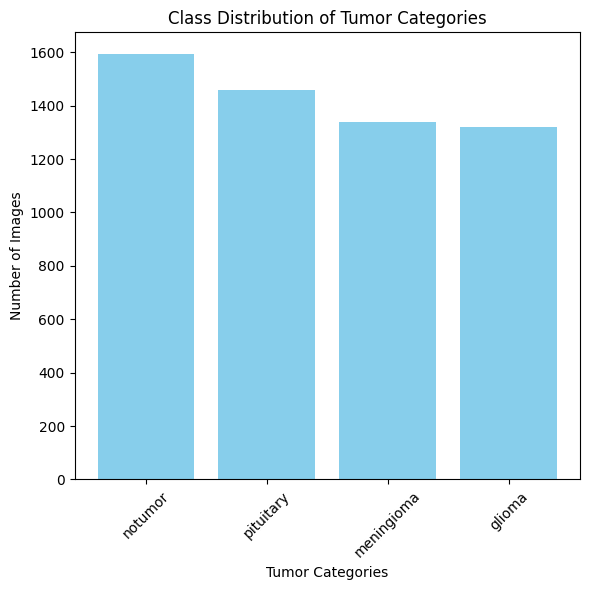

In [ ]:
#class distribution plot is most important to see the dataset balance/ imbalancement

def plot_class_distribution(dataset_dir):
    """
    Plots the distribution of images across different tumor categories in the dataset.

    Parameters:
    dataset_dir (str): Directory path containing subdirectories for each tumor category.
    """
    categories = os.listdir(dataset_dir)
    category_counts = []

    for category in categories:
        category_path = os.path.join(dataset_dir, category)
        if os.path.isdir(category_path):
            num_images = len(os.listdir(category_path))
            category_counts.append((category, num_images))

    category_counts.sort(key=lambda x: x[1], reverse=True)  # Sort categories by number of images

    categories, counts = zip(*category_counts)

    plt.figure(figsize=(6, 6))
    plt.bar(categories, counts, color='skyblue')
    plt.xlabel('Tumor Categories')
    plt.ylabel('Number of Images')
    plt.title('Class Distribution of Tumor Categories')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


dataset_dir = 'cleaned/Training'
plot_class_distribution(dataset_dir)

Category: notumor
Mean Pixel Value: 89.77823929263506
Standard Deviation of Pixel Values: 54.12784684816836
Minimum Pixel Value: 0
Maximum Pixel Value: 255

Category: meningioma
Mean Pixel Value: 68.57615028022384
Standard Deviation of Pixel Values: 44.775508946965104
Minimum Pixel Value: 0
Maximum Pixel Value: 255

Category: glioma
Mean Pixel Value: 56.28941563527572
Standard Deviation of Pixel Values: 35.90628528686301
Minimum Pixel Value: 0
Maximum Pixel Value: 255

Category: pituitary
Mean Pixel Value: 61.949515893186046
Standard Deviation of Pixel Values: 37.953422958466774
Minimum Pixel Value: 0
Maximum Pixel Value: 255

Minimum values: [0, 0, 0, 0]


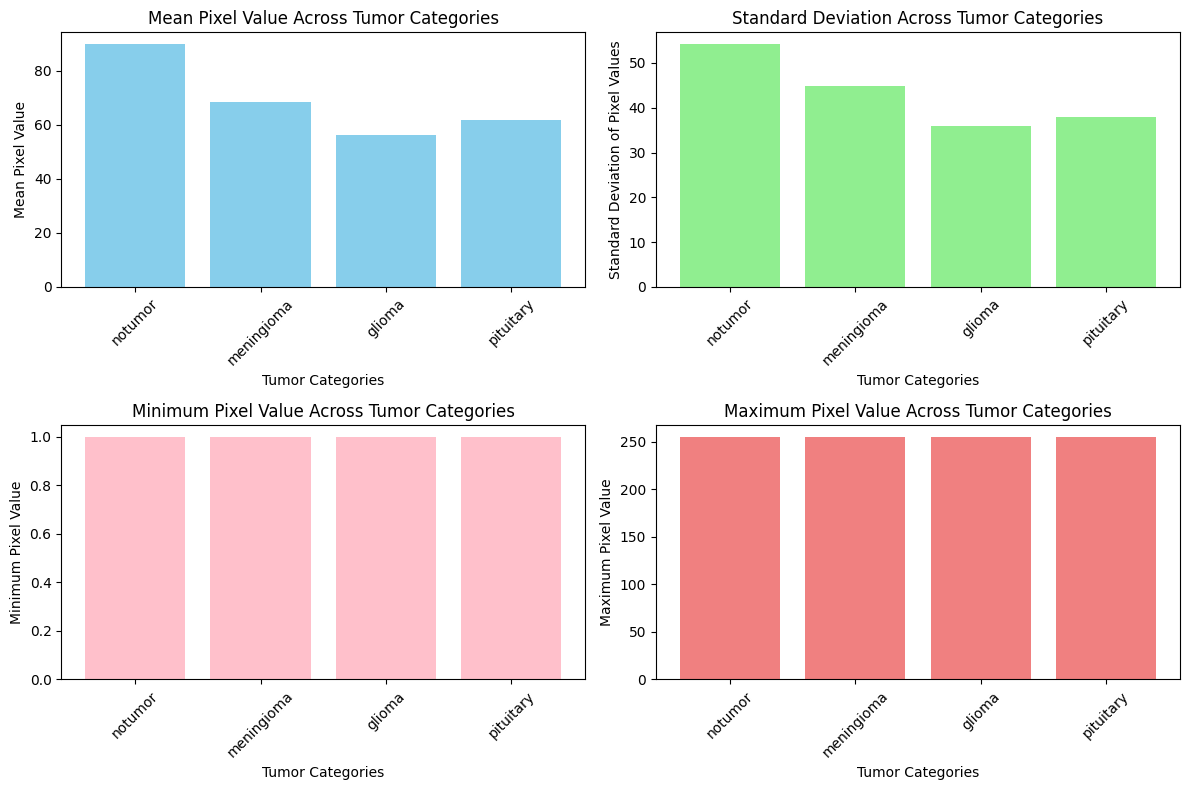

In [ ]:
def calculate_image_statistics(dataset_dir):
    """
    Calculates statistical metrics (mean, std deviation, range) of pixel values within images in the dataset.

    Parameters:
    dataset_dir (str): Directory path containing subdirectories for each tumor category.

    Returns:
    dict: Dictionary containing statistical metrics (mean, std_dev, min_value, max_value) for each image category.
    """
    categories = os.listdir(dataset_dir)
    category_statistics = {}

    for category in categories:
        category_path = os.path.join(dataset_dir, category)
        if os.path.isdir(category_path):
            image_stats = {
                'mean': [],
                'std_dev': [],
                'min_value': [],
                'max_value': []
            }

            for img_name in os.listdir(category_path):
                img_path = os.path.join(category_path, img_name)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Read image in grayscale mode
                if img is not None:
                    mean_value = np.mean(img)
                    std_dev_value = np.std(img)
                    min_value = np.min(img)
                    max_value = np.max(img)

                    image_stats['mean'].append(mean_value)
                    image_stats['std_dev'].append(std_dev_value)
                    image_stats['min_value'].append(min_value)
                    image_stats['max_value'].append(max_value)

            category_statistics[category] = {
                'mean': np.mean(image_stats['mean']),
                'std_dev': np.mean(image_stats['std_dev']),
                'min_value': np.min(image_stats['min_value']),
                'max_value': np.max(image_stats['max_value'])
            }

    return category_statistics

def plot_statistics(stats):
    """
    Plot graphical representation of image statistics.

    Parameters:
    stats (dict): Dictionary containing statistical metrics for each image category.
    """
    categories = list(stats.keys())
    mean_values = [stats[cat]['mean'] for cat in categories]
    std_dev_values = [stats[cat]['std_dev'] for cat in categories]
    min_values = [stats[cat]['min_value'] for cat in categories]
    max_values = [stats[cat]['max_value'] for cat in categories]

    # Debug: Print the calculated minimum values
    print("Minimum values:", min_values)

    plt.figure(figsize=(12, 8))

    plt.subplot(2, 2, 1)
    plt.bar(categories, mean_values, color='skyblue')
    plt.xlabel('Tumor Categories')
    plt.ylabel('Mean Pixel Value')
    plt.title('Mean Pixel Value Across Tumor Categories')
    plt.xticks(rotation=45)

    plt.subplot(2, 2, 2)
    plt.bar(categories, std_dev_values, color='lightgreen')
    plt.xlabel('Tumor Categories')
    plt.ylabel('Standard Deviation of Pixel Values')
    plt.title('Standard Deviation Across Tumor Categories')
    plt.xticks(rotation=45)

    plt.subplot(2, 2, 3)
    min_values = [v + 1 for v in min_values]  # Add 1 to all min values for better visualization
    plt.bar(categories, min_values, color='pink')
    plt.xlabel('Tumor Categories')
    plt.ylabel('Minimum Pixel Value')
    plt.title('Minimum Pixel Value Across Tumor Categories')
    plt.xticks(rotation=45)

    plt.subplot(2, 2, 4)
    plt.bar(categories, max_values, color='lightcoral')
    plt.xlabel('Tumor Categories')
    plt.ylabel('Maximum Pixel Value')
    plt.title('Maximum Pixel Value Across Tumor Categories')
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

# Set the dataset directory
dataset_dir = 'cleaned/Training'

# Calculate statistics
stats = calculate_image_statistics(dataset_dir)

# Print the calculated statistics for debugging
for category, stat in stats.items():
    print(f"Category: {category}")
    print(f"Mean Pixel Value: {stat['mean']}")
    print(f"Standard Deviation of Pixel Values: {stat['std_dev']}")
    print(f"Minimum Pixel Value: {stat['min_value']}")
    print(f"Maximum Pixel Value: {stat['max_value']}")
    print()

# Plot the statistics graphically
plot_statistics(stats)


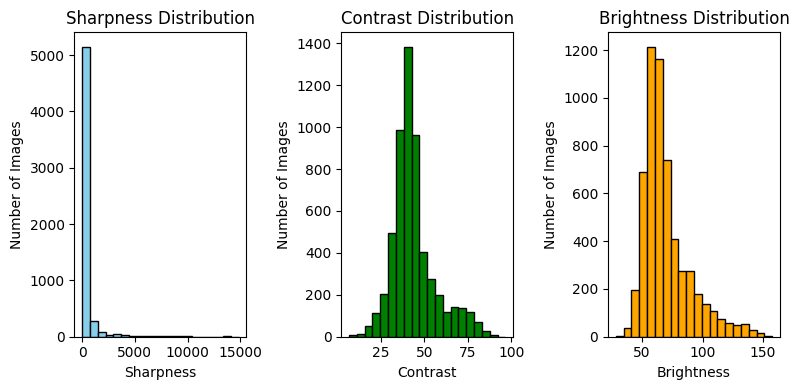

In [ ]:

def calculate_image_quality_metrics(img_path):
    """
    Calculates image quality metrics including sharpness, contrast, and brightness.

    Parameters:
    img_path (str): Path to the image file.

    Returns:
    dict: Dictionary containing image quality metrics.
    """
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Read image as grayscale
    if img is None:
        raise ValueError(f"Unable to read image: {img_path}")

    # Calculate sharpness (high frequency content)
    laplacian_var = cv2.Laplacian(img, cv2.CV_64F).var()
    sharpness = laplacian_var

    # Calculate contrast (pixel intensity range)
    contrast = np.std(img)

    # Calculate brightness (mean pixel value)
    brightness = np.mean(img)

    metrics = {
        'sharpness': sharpness,
        'contrast': contrast,
        'brightness': brightness
    }

    return metrics

def analyze_image_quality(dataset_dir):
    """
    Analyzes image quality metrics (sharpness, contrast, brightness) for images in a dataset directory.

    Parameters:
    dataset_dir (str): Directory containing image files.

    Returns:
    dict: Dictionary containing image quality metrics for each image file.
    """
    sharpness_values = []
    contrast_values = []
    brightness_values = []

    for category in os.listdir(dataset_dir):
        category_path = os.path.join(dataset_dir, category)
        if os.path.isdir(category_path):
            for img_name in os.listdir(category_path):
                img_path = os.path.join(category_path, img_name)
                try:
                    metrics = calculate_image_quality_metrics(img_path)
                    sharpness_values.append(metrics['sharpness'])
                    contrast_values.append(metrics['contrast'])
                    brightness_values.append(metrics['brightness'])
                except Exception as e:
                    print(f"Error processing {img_path}: {str(e)}")

    return sharpness_values, contrast_values, brightness_values


dataset_dir = 'cleaned/Training'  # Replace with your dataset directory
sharpness_values, contrast_values, brightness_values = analyze_image_quality(dataset_dir)

# Plotting
plt.figure(figsize=(8, 4))

# Plot sharpness
plt.subplot(1, 3, 1)
plt.hist(sharpness_values, bins=20, color='skyblue', edgecolor='black')
plt.title('Sharpness Distribution')
plt.xlabel('Sharpness')
plt.ylabel('Number of Images')

# Plot contrast
plt.subplot(1, 3, 2)
plt.hist(contrast_values, bins=20, color='green', edgecolor='black')
plt.title('Contrast Distribution')
plt.xlabel('Contrast')
plt.ylabel('Number of Images')

# Plot brightness
plt.subplot(1, 3, 3)
plt.hist(brightness_values, bins=20, color='orange', edgecolor='black')
plt.title('Brightness Distribution')
plt.xlabel('Brightness')
plt.ylabel('Number of Images')

plt.tight_layout()
plt.show()


# Applying under-sampling technique:
exploratory data analysis (EDA) reveals that the "no tumor" category has more images compared to the other categories (pituitary, meningioma, and glioma), it could potentially impact the training and performance of machine learning model, so to metigate this error undersampling technique is used. Undersampling is a technique used to balance class distribution by reducing the number of instances in the majority class(es) to match the minority class.

In [ ]:


def undersample_dataset(input_dir, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    categories = os.listdir(input_dir)
    num_samples_per_class = None

    # Find the category with the fewest images (assumed as the minority class)
    for category in categories:
        category_path = os.path.join(input_dir, category)
        if os.path.isdir(category_path):
            num_images = len(os.listdir(category_path))
            if num_samples_per_class is None or num_images < num_samples_per_class:
                num_samples_per_class = num_images

    # Undersample each category to match num_samples_per_class
    for category in categories:
        category_path = os.path.join(input_dir, category)
        output_category_path = os.path.join(output_dir, category)

        if os.path.isdir(category_path):
            if not os.path.exists(output_category_path):
                os.makedirs(output_category_path)

            image_list = os.listdir(category_path)
            random.shuffle(image_list)  # Shuffle images for random selection

            for img_name in image_list[:num_samples_per_class]:
                src_path = os.path.join(category_path, img_name)
                dst_path = os.path.join(output_category_path, img_name)
                shutil.copy(src_path, dst_path)


input_dir = 'cleaned/Training'
output_dir = 'balanced_dataset/Training'  # Directory to store undersampled dataset

undersample_dataset(input_dir, output_dir)

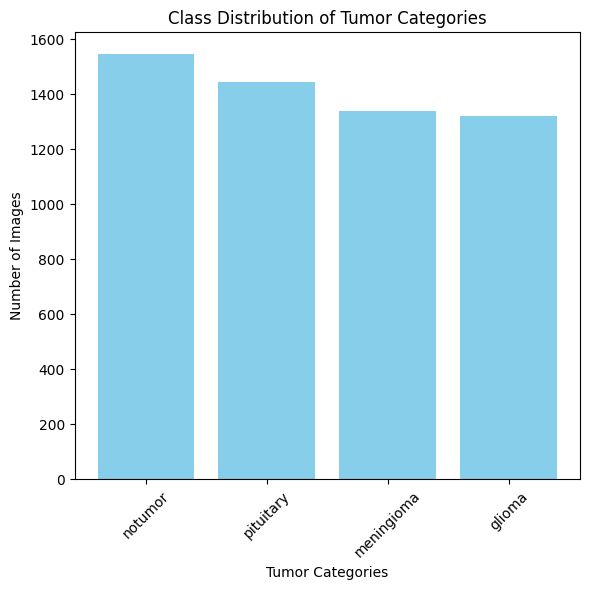

In [ ]:
#simply calling the class distribution plot function to visualise the classes samples after
#applying under sampling technique

plot_class_distribution(output_dir)

# **Crerating Model EDN-SVM (Ensemble Deep Neural Support Vector Machine):**
To apply the Ensemble Deep Neural Support Vector Machine (EDSVM) algorithm to preprocessed or cleaned dataset, we'll need to integrate both a deep neural network (DNN) and a support vector machine (SVM) into a cohesive model.

In [ ]:
train_dir = 'balanced_dataset/Training'
test_dir = 'cleaned/Testing'

# Image data generators for training and testing datasets
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical'
)

Found 5652 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


**Defining the DEEP NEURAL NETWORK MODEL:**
It will serve as a feature extractor

In [ ]:
def create_cnn_model(input_shape=(256, 256, 3)):
    """
    Creates and returns a Convolutional Neural Network (CNN) model using the Keras Sequential API.

    Parameters:
    input_shape (tuple): The shape of the input data (height, width, channels). Default is (256, 256, 3).

    Returns:
    model (Sequential): A Keras Sequential model representing the CNN.
    """
    model = Sequential()  # Initialize the Sequential model

    # Add an Input layer with the shape of the input data
    model.add(Input(shape=input_shape))

    # Add the first convolutional layer with 32 filters and a 3x3 kernel, ReLU activation
    model.add(Conv2D(32, (3, 3), activation='relu'))
    # Add a max pooling layer with a 2x2 pool size
    model.add(MaxPooling2D((2, 2)))

    # Add the second convolutional layer with 64 filters and a 3x3 kernel, followed by a max pooling layer
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    # Add the third convolutional layer with 128 filters and a 3x3 kernel, followed by a max pooling layer
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    # Flatten the output of the previous layer to create a 1D feature vector
    model.add(Flatten())

    # Add a fully connected (dense) layer with 128 units and ReLU activation
    model.add(Dense(128, activation='relu'))

    # Add a dropout layer with a rate of 0.5 to prevent overfitting
    model.add(Dropout(0.5))

    # Add the output layer with 4 units (one for each class) and softmax activation for classification
    model.add(Dense(4, activation='softmax'))

    # Compile the model with the Adam optimizer, categorical crossentropy loss function, and accuracy metric
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# Create an instance of the CNN model
cnn_model = create_cnn_model()
cnn_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)                    │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 60, 60, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 30, 30, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 115200)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │      14,745,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,839,492 (56.61 MB)

 Trainable params: 14,839,492 (56.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
epochs = 20


early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = cnn_model.fit(
    train_generator,
    epochs=epochs,
    validation_data=test_generator,
    callbacks=[early_stopping]
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


177/177 ━━━━━━━━━━━━━━━━━━━━ 27s 136ms/step - accuracy: 0.5029 - loss: 1.2020 - val_accuracy: 0.7551 - val_loss: 0.6388
Epoch 2/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 15s 82ms/step - accuracy: 0.7683 - loss: 0.5891 - val_accuracy: 0.7811 - val_loss: 0.5445
Epoch 3/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 21s 117ms/step - accuracy: 0.8320 - loss: 0.4470 - val_accuracy: 0.8421 - val_loss: 0.4029
Epoch 4/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 15s 83ms/step - accuracy: 0.8768 - loss: 0.3295 - val_accuracy: 0.8688 - val_loss: 0.3429
Epoch 5/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 15s 84ms/step - accuracy: 0.9010 - loss: 0.2516 - val_accuracy: 0.8780 - val_loss: 0.3157
Epoch 6/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 15s 82ms/step - accuracy: 0.9262 - loss: 0.2067 - val_accuracy: 0.8856 - val_loss: 0.2894
Epoch 7/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 21s 84ms/step - accuracy: 0.9448 - loss: 0.1528 - val_accuracy: 0.9069 - val_loss: 0.2814
Epoch 8/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 16s 86ms/step - accuracy: 0.9461 - loss: 0.1368 - val_accur

In [ ]:
# Plotting training and validation accuracy and loss

def plot_training_history(history):
    """
    Plots the training and validation accuracy and loss over epochs.

    Parameters:
    history (History object): History object returned by the fit method of the model.
    """
    # Extract the accuracy and loss values for training and validation
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    # Plot training and validation accuracy
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot training and validation loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()


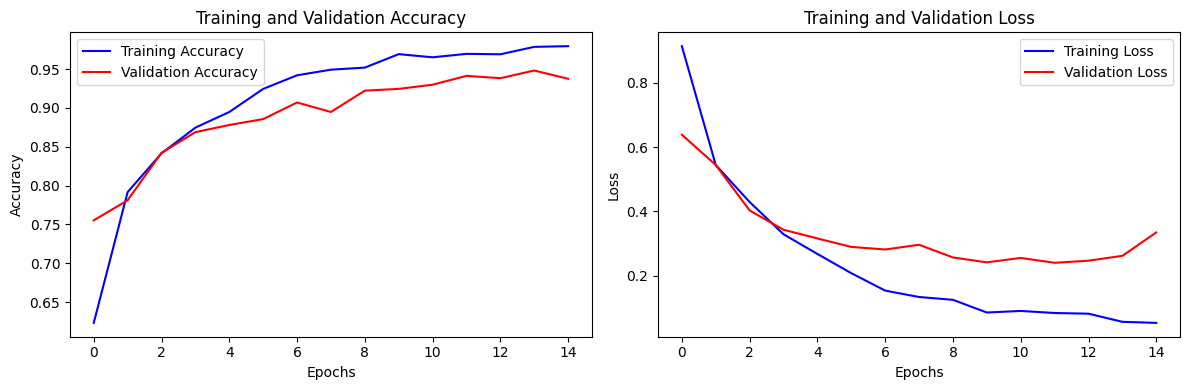

In [ ]:

# Plot the training history
plot_training_history(history)

**Extracting Features from trained CNN**

In [ ]:
# Function to extract features using the CNN
def extract_features(model, generator):
    features = []
    labels = []
    for inputs, targets in generator:
        features_batch = model.predict(inputs)
        features.append(features_batch)
        labels.append(targets)
        if len(features) * generator.batch_size >= generator.samples:
            break

    features = np.vstack(features)
    labels = np.vstack(labels)
    return features, labels

# Remove the last layer of the CNN to get features
feature_extractor = Sequential(cnn_model.layers[:-1])

train_features, train_labels = extract_features(feature_extractor, train_generator)
test_features, test_labels = extract_features(feature_extractor, test_generator)

# Convert labels from one-hot encoding to integers
train_labels = np.argmax(train_labels, axis=1)
test_labels = np.argmax(test_labels, axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━

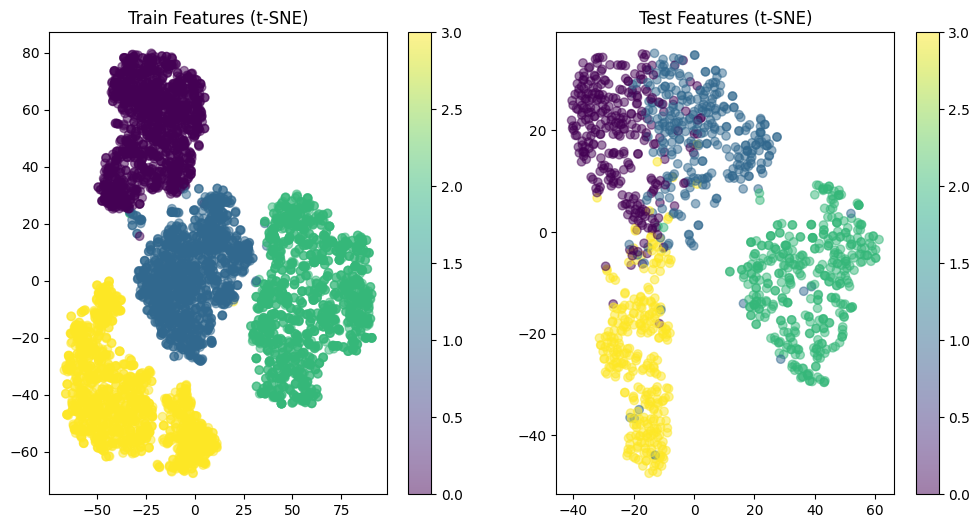

In [ ]:
from sklearn.manifold import TSNE

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=0)
train_features_2d = tsne.fit_transform(train_features)
test_features_2d = tsne.fit_transform(test_features)

# Create scatter plot
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(train_features_2d[:, 0], train_features_2d[:, 1], c=train_labels, cmap='viridis', alpha=0.5)
plt.colorbar()
plt.title('Train Features (t-SNE)')

plt.subplot(1, 2, 2)
plt.scatter(test_features_2d[:, 0], test_features_2d[:, 1], c=test_labels, cmap='viridis', alpha=0.5)
plt.colorbar()
plt.title('Test Features (t-SNE)')

plt.show()

**training SVM on extracted features**

In [ ]:
# Create and train the SVM model

# Create an SVM model pipeline
# The pipeline includes a StandardScaler for normalization and an SVC with a linear kernel
svm_model = make_pipeline(StandardScaler(), SVC(kernel='linear', probability=True))

# Fit the SVM model on the training data
# train_features: The feature vectors extracted from the training images
# train_labels: The corresponding labels for the training images
svm_model.fit(train_features, train_labels)


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(kernel='linear', probability=True))])

In [ ]:

def plot_confusion_matrix(y_true, y_pred, classes, title='Confusion Matrix'):
    """
    Plots a confusion matrix using true and predicted labels.

    Parameters:
    y_true (array-like): True labels.
    y_pred (array-like): Predicted labels.
    classes (list): List of class names.
    title (str): Title of the confusion matrix plot.
    """
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Define class names
class_names = list(train_generator.class_indices.keys())

In [ ]:

# Predict using the SVM model
test_predictions = svm_model.predict(test_features)

# Evaluate the predictions
print("Classification Report:")
print(classification_report(test_labels, test_predictions))
print("Accuracy:", accuracy_score(test_labels, test_predictions))

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.90      0.91       300
           1       0.90      0.92      0.91       306
           2       0.99      1.00      1.00       405
           3       0.97      0.96      0.96       300

    accuracy                           0.95      1311
   macro avg       0.94      0.94      0.94      1311
weighted avg       0.95      0.95      0.95      1311

Accuracy: 0.9473684210526315


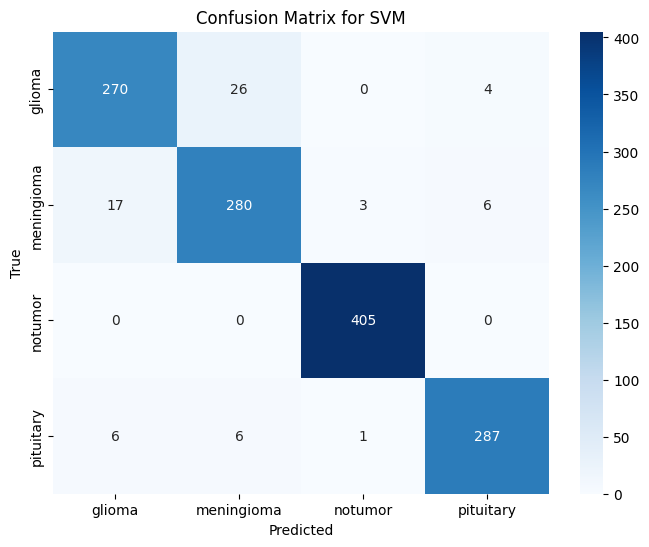

In [ ]:
#Plotting the confusion matrix for SVM
plot_confusion_matrix(test_labels, test_predictions, class_names, title='Confusion Matrix for SVM')


**Ensembling CNN with SVM to make it EDN-SVM:**

This model that combines the predictions from both the CNN and the SVM for better performance. It integrates a CNN for feature extraction and an SVM for classification, utilizing the strengths of both techniques. The ensemble approach at the end aims to further improve classification performance.

In [ ]:
def ensemble_predict(cnn_model, svm_model, test_generator):
    cnn_predictions = cnn_model.predict(test_generator)
    svm_predictions = svm_model.predict_proba(test_features)

    final_predictions = (cnn_predictions + svm_predictions) / 2
    return np.argmax(final_predictions, axis=1)

ensemble_predictions = ensemble_predict(cnn_model, svm_model, test_generator)

# Evaluate the ensemble model
print("Ensemble Classification Report:")
print(classification_report(test_labels, ensemble_predictions))
print("Ensemble Accuracy:", accuracy_score(test_labels, ensemble_predictions))

41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step
Ensemble Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.90      0.91       300
           1       0.89      0.92      0.90       306
           2       0.99      1.00      0.99       405
           3       0.97      0.96      0.96       300

    accuracy                           0.95      1311
   macro avg       0.94      0.94      0.94      1311
weighted avg       0.95      0.95      0.95      1311

Ensemble Accuracy: 0.9473684210526315


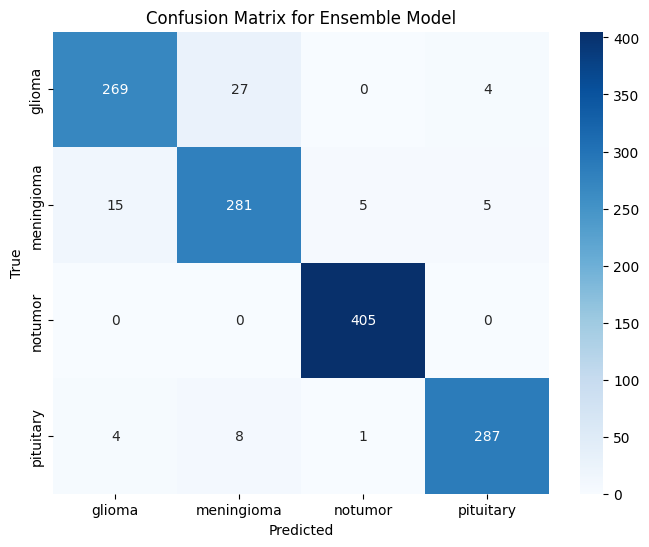

In [ ]:
# Plot confusion matrix for ensemble model
plot_confusion_matrix(test_labels, ensemble_predictions, class_names, title='Confusion Matrix for Ensemble Model')

41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 162ms/step


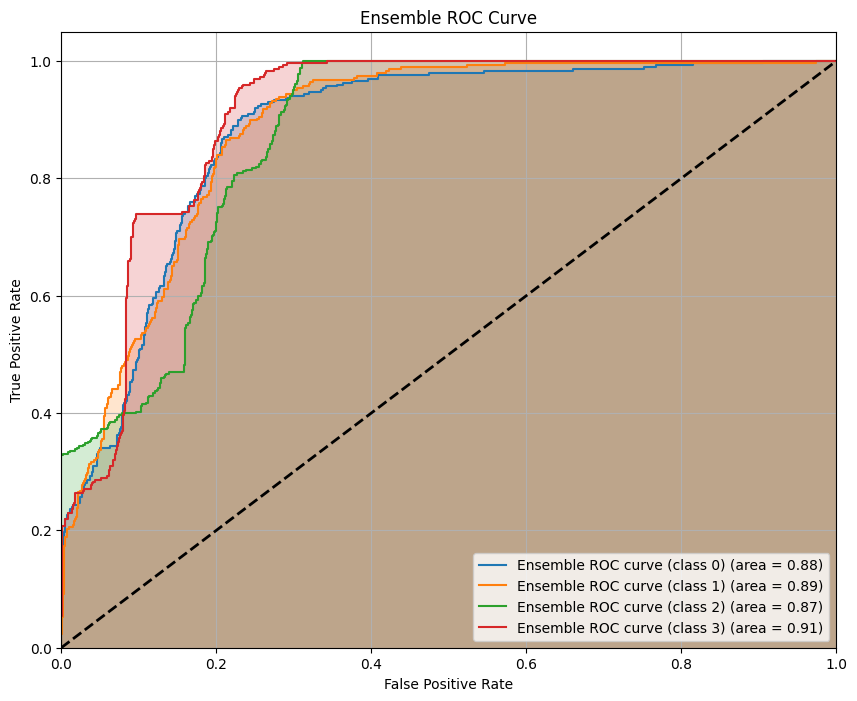

In [ ]:


# Binarize the labels for ROC curve computation
test_labels_bin = label_binarize(test_labels, classes=[0, 1, 2, 3])

# Assuming svm_predictions_prob and cnn_model.predict(test_generator) are already computed
svm_predictions_prob = svm_model.predict_proba(test_features)
ensemble_predictions_prob = (cnn_model.predict(test_generator) + svm_predictions_prob) / 2

# Plot ROC curves for each class for Ensemble model
plt.figure(figsize=(10, 8))  # figure size
for i in range(4):
    fpr, tpr, _ = roc_curve(test_labels_bin[:, i], ensemble_predictions_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Ensemble ROC curve (class {i}) (area = {roc_auc:.2f})')
    plt.fill_between(fpr, tpr, alpha=0.2)

# Plot random classifier baseline
plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Add a dashed line for random classifier

# Gridlines
plt.grid(True)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Ensemble ROC Curve')
plt.legend(loc="lower right")
plt.show()


41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step


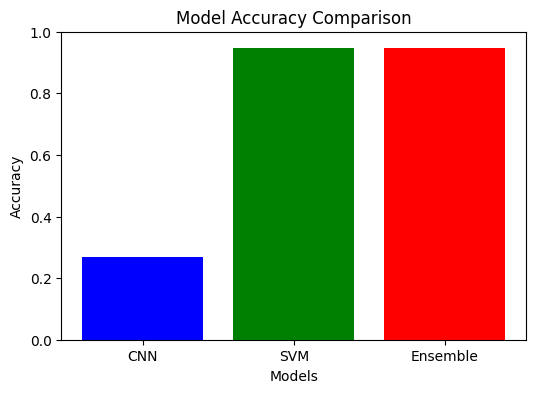

In [ ]:
# Comparison bar chart for accuracy
models = ['CNN', 'SVM', 'Ensemble']
accuracies = [accuracy_score(test_labels, np.argmax(cnn_model.predict(test_generator), axis=1)),
              accuracy_score(test_labels, test_predictions),
              accuracy_score(test_labels, ensemble_predictions)]

plt.figure(figsize=(6, 4))
plt.bar(models, accuracies, color=['blue', 'green', 'red'])
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.ylim([0, 1])
plt.show()